In [1]:
import sys
!conda install --yes --prefix {sys.prefix} descartes

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Nico\Anaconda

  added / updated specs:
    - descartes


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1k             |       h2bbff1b_0         4.8 MB
    ------------------------------------------------------------
                                           Total:         4.8 MB

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2020.12.~ --> pkgs/main::ca-certificates-2021.1.19-haa95532_1

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge::certifi-2020.12.5-py38ha~ --> pkgs/main::certifi-2020.12.5-py38haa95532_0
  conda              conda-forge::conda-4.9.2-py38haa244fe~ --> pkgs/main::conda-4.9.2-py38haa95532_0
  openssl            conda-forge::openssl-1.1.1k-h8ffe710_0 --> pkgs/ma

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import folium
import math
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from mpl_toolkits.axes_grid1 import make_axes_locatable
base_dir = 'D:/Università/Tirocinio/Analisi Dati/Dati/'

In [3]:
files = [
#'MarcheQuakeArea_20150416_20150427_24.csv',
#'MarcheQuakeArea_20150516_20150527_24.csv',
#'MarcheQuakeArea_20150916_20150927_24.csv',
#'MarcheQuakeArea_20160416_20160427_24.csv',
'MarcheQuakeArea_20160516_20160527_24.csv',
#'MarcheQuakeArea_20160816_20160901_24.csv', # mese del terremoto
'MarcheQuakeArea_20160916_20160927_24.csv',
'MarcheQuakeArea_20161016_20161027_24.csv',
'MarcheQuakeArea_20170416_20170427_24.csv',
'MarcheQuakeArea_20170516_20170527_24.csv',
'MarcheQuakeArea_20170916_20170927_24.csv',
'MarcheQuakeArea_20171016_20171027_24.csv',
'MarcheQuakeArea_20180401_20180413_24.csv'
]

def process_file(file, night_only=True):
    data = pd.read_csv(base_dir+'dataset/'+file)
    data['rtime'] = pd.to_datetime(data['time'], format = '%Y%m%d_%H%M')
    if night_only:
        data['hour'] = data['rtime'].dt.hour
        data = data[(data['hour'] < 7) | (data['hour'] > 21)]
        data = data.drop(['hour'],axis='columns')
        
    first_date = pd.to_datetime(data.iloc[0,0], format = '%Y%m%d_%H%M')
    #last_date = pd.to_datetime(data.iloc[-1,0], format = '%Y%m%d_%H%M')
    #mid_date = fist_date + (last_date - fist_date) / 2
    data = data.drop(['time','rtime','base2mid'],axis='columns').groupby(['assoc_comuni','RER_32'])['val'].mean().reset_index()
    data.columns = ['assoc_comuni','RER_32','val'+'_{}_{}'.format(first_date.year,first_date.month)]
    return data


data = process_file(files[0])
for i in range(1,len(files)):
    data = data.merge(process_file(files[i]))
data.head(2)


,assoc_comuni,RER_32,val_2016_5,val_2016_9,val_2016_10,val_2017_4,val_2017_5,val_2017_9,val_2017_10,val_2018_4
0,Acquacanina,1.0,626.741414,623.013131,598.180808,525.503030,495.910101,505.887879,516.918182,540.284906
1,Agugliano,0.0,4932.067821,4859.905483,4807.860029,4739.233045,4853.440115,4661.775613,5604.766234,4969.345013


In [4]:
#ts.index= ts['rtime']


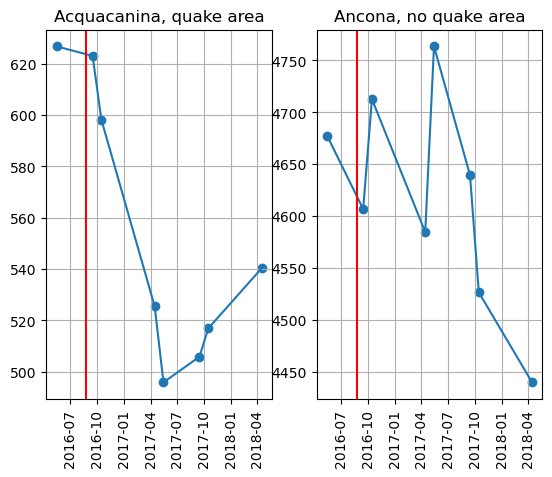

In [19]:
def name2datetime(name):
    ym = name[3:].replace('_','')
    return datetime.strptime(ym+'15_0000','%Y%m%d_%H%M')


def plot(data,comune):
    ts = data[data['assoc_comuni']==comune]
    ts = ts.melt(id_vars =['assoc_comuni','RER_32'], value_vars = list(ts.columns[2:]))
    ts['time'] = ts['variable'].apply(name2datetime)
    plt.plot(ts['time'], ts['value'])
    plt.scatter(ts['time'], ts['value'])
    hq = 'quake area' if ts.iloc[0,1] == 1 else 'no quake area'
    plt.title(comune+', '+hq)
    plt.xticks(rotation=90)
    plt.grid()
    hq_time = datetime.strptime('20160824_0336','%Y%m%d_%H%M')
    if ts['time'].min() < hq_time and hq_time < ts['time'].max():
        plt.axvline(hq_time, color='#ff0000')
#Camerino
plt.subplot(1, 2, 1)
plot(data,'Acquacanina')
plt.subplot(1, 2, 2)
plot(data,'Ancona')
plt.show()



**Fig. 1** population change during months before and after the earthquake. Camerino is inide the quake area, Ancona in not. Pay attention to y-axis


In [6]:
diff = data.copy()
for i in range(3,data.shape[1]):
    diff.iloc[:,i] = (diff.iloc[:,i] - diff.iloc[:,2]) / diff.iloc[:,2] * 100
#diff = diff[diff.iloc[:,2] > 500]    
diff.iloc[:,2] = 0
print(diff.shape)
diff.head()



(146, 10)


,assoc_comuni,RER_32,val_2016_5,val_2016_9,val_2016_10,val_2017_4,val_2017_5,val_2017_9,val_2017_10,val_2018_4
0,Acquacanina,1.0,0,-0.594868,-4.557000,-16.153135,-20.874847,-19.282839,-17.522894,-13.794606
1,Agugliano,0.0,0,-1.463125,-2.518372,-3.909816,-1.594214,-5.480302,13.639277,0.755813
2,Altidona,0.0,0,4.722041,-1.393896,30.645791,10.407899,12.450712,14.540387,21.376127
3,Amandola,1.0,0,4.040538,1.867666,-5.789720,-4.484021,-16.467667,-14.979643,-10.535414
4,Ancona,0.0,0,-1.510724,0.755690,-1.984725,1.842147,-0.812044,-3.226821,-5.080306


  assoc_comuni  RER_32     variable      value       time
0     Camerino     1.0   val_2016_5   0.000000 2016-05-15
1     Camerino     1.0   val_2016_9  -8.989253 2016-09-15
2     Camerino     1.0  val_2016_10  -2.372695 2016-10-15
3     Camerino     1.0   val_2017_4 -28.031928 2017-04-15
4     Camerino     1.0   val_2017_5 -21.745167 2017-05-15
5     Camerino     1.0   val_2017_9 -25.521204 2017-09-15
6     Camerino     1.0  val_2017_10 -25.968719 2017-10-15
7     Camerino     1.0   val_2018_4 -28.733511 2018-04-15
  assoc_comuni  RER_32     variable      value       time
0      Fiastra     1.0   val_2016_5   0.000000 2016-05-15
1      Fiastra     1.0   val_2016_9   0.442871 2016-09-15
2      Fiastra     1.0  val_2016_10   2.870311 2016-10-15
3      Fiastra     1.0   val_2017_4 -21.062231 2017-04-15
4      Fiastra     1.0   val_2017_5 -26.526686 2017-05-15
5      Fiastra     1.0   val_2017_9 -19.552983 2017-09-15
6      Fiastra     1.0  val_2017_10 -21.447399 2017-10-15
7      Fiastra

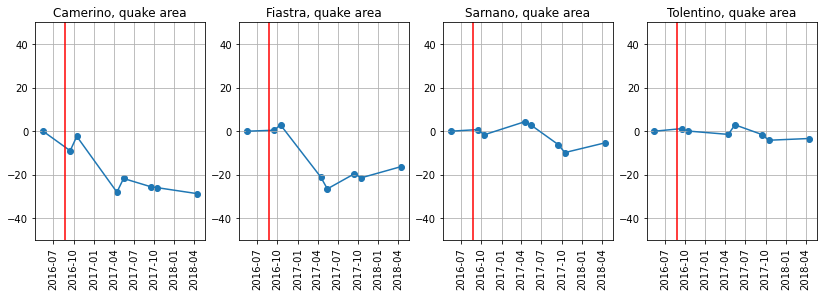

In [7]:
plt.rcParams['figure.figsize'] = [14, 4]
plt.subplot(1, 4, 1)
plt.ylim(-50,50)
plot(diff,'Camerino')
plt.subplot(1, 4, 2)
plt.ylim(-50,50)
plot(diff,'Fiastra')
plt.subplot(1, 4, 3)
plt.ylim(-50,50)
plot(diff,'Sarnano')
plt.subplot(1, 4, 4)
plt.ylim(-50,50)
plot(diff,'Tolentino')
plt.show()
plt.rcParams.update(plt.rcParamsDefault)

**Fig. 2**  Percentage difference in population between May 2016 (before the earthquake) and months after

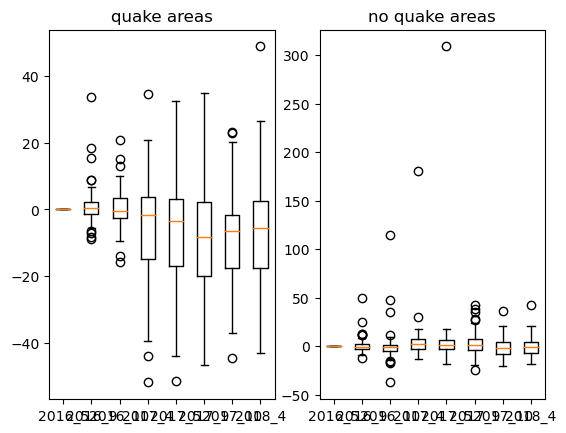

In [8]:

diff_hq = diff[diff['RER_32']==1]
diff_no_hq = diff[diff['RER_32']==0]

boxplot_hq = []
boxplot_no_hq = []
labels = []
for i in range(2,data.shape[1]):
    boxplot_hq.append(diff_hq.iloc[:,i])
    boxplot_no_hq.append(diff_no_hq.iloc[:,i])
    labels.append(diff.columns[i][4:])


plt.subplot(1, 2, 1)
plt.boxplot(boxplot_hq,showfliers=True)
plt.title('quake areas')
plt.xticks(range(1,len(labels)+1), labels)
plt.subplot(1, 2, 2)
plt.boxplot(boxplot_no_hq,showfliers=True)
plt.title('no quake areas')
plt.xticks(range(1,len(labels)+1), labels)

plt.show()

**Fig. 3** Boxplot showing the distribution of the percentage difference in population between May 2016 (before the earthquake) and months after. 

In [9]:
#clean data (it cleans the main outlier above)

#diff = diff.drop(diff_no_hq[diff_no_hq['val_2016_10']>100].index[0])
#diff = diff.drop(diff_no_hq[diff_no_hq['val_2017_4']>100].index[0])

In [10]:
map = gpd.read_file(base_dir+'shp/Comuni2016/marche.shp')
crateri = pd.read_csv(base_dir+'other_data/crateriCentroIT.csv',sep=';')
crateri.columns = ['PROV','COMUNE','HQ']
print(crateri.shape)
print(map.shape)
map = map.merge(crateri,how='left')
map['HQ'] = map['HQ'].fillna(0)
print(map.shape)
map = map.loc[:,['COMUNE','geometry','HQ']]
map.head(2)

(131, 3)
(236, 13)
(236, 15)


,COMUNE,geometry,HQ
0,Ripatransone,"POLYGON ((13.79857 43.03372, 13.79856 43.03366...",0.0
1,Trecastelli,"POLYGON ((13.11299 43.72705, 13.11340 43.72703...",0.0


In [11]:
diff = diff.rename({'assoc_comuni':'COMUNE'}, axis='columns') #renaming columns
map_diff = map.merge(diff)
map_diff.head(2)

,COMUNE,geometry,HQ,RER_32,val_2016_5,val_2016_9,val_2016_10,val_2017_4,val_2017_5,val_2017_9,val_2017_10,val_2018_4
0,Ripatransone,"POLYGON ((13.79857 43.03372, 13.79856 43.03366...",0.0,0.0,0,0.373485,-2.848801,7.722038,1.104820,-2.842583,-5.115354,-0.345692
1,Trecastelli,"POLYGON ((13.11299 43.72705, 13.11340 43.72703...",0.0,0.0,0,-2.348909,4.734302,13.235994,11.603933,-0.513404,1.561456,0.227669


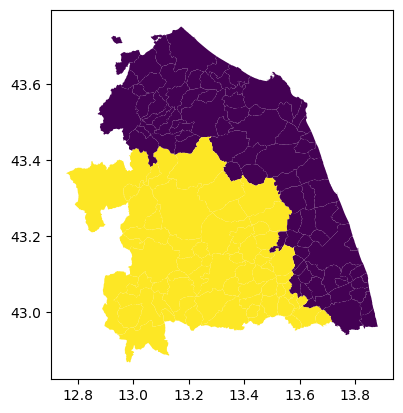

In [12]:
map_diff['HQ'].value_counts()
map_diff.plot(column='HQ');

**Fig. 4** Area under observation. Yellow is for quake areas. Purple not affected areas

In [13]:
'''
for i in range(5,len(map_diff.columns)-1):
    x = map_diff.columns[i]
    bp = plt.boxplot(map_diff[x])
    outliers = list([flier.get_ydata() for flier in bp["fliers"]][0])    
    map_diff.loc[((map_diff[x].isin(outliers))&(map_diff[x] > 0)),x] = np.NaN
map_diff_clean = map_diff
map_diff_clean.info()
'''

for i in range(5,len(map_diff.columns)-1):
    x = map_diff.columns[i]   
    map_diff.loc[map_diff[x] > 100,x] = np.NaN
map_diff_clean = map_diff
map_diff_clean.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 146 entries, 0 to 145
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   COMUNE       146 non-null    object  
 1   geometry     146 non-null    geometry
 2   HQ           146 non-null    float64 
 3   RER_32       146 non-null    float64 
 4   val_2016_5   146 non-null    int64   
 5   val_2016_9   146 non-null    float64 
 6   val_2016_10  145 non-null    float64 
 7   val_2017_4   145 non-null    float64 
 8   val_2017_5   145 non-null    float64 
 9   val_2017_9   146 non-null    float64 
 10  val_2017_10  146 non-null    float64 
 11  val_2018_4   146 non-null    float64 
dtypes: float64(9), geometry(1), int64(1), object(1)
memory usage: 14.8+ KB


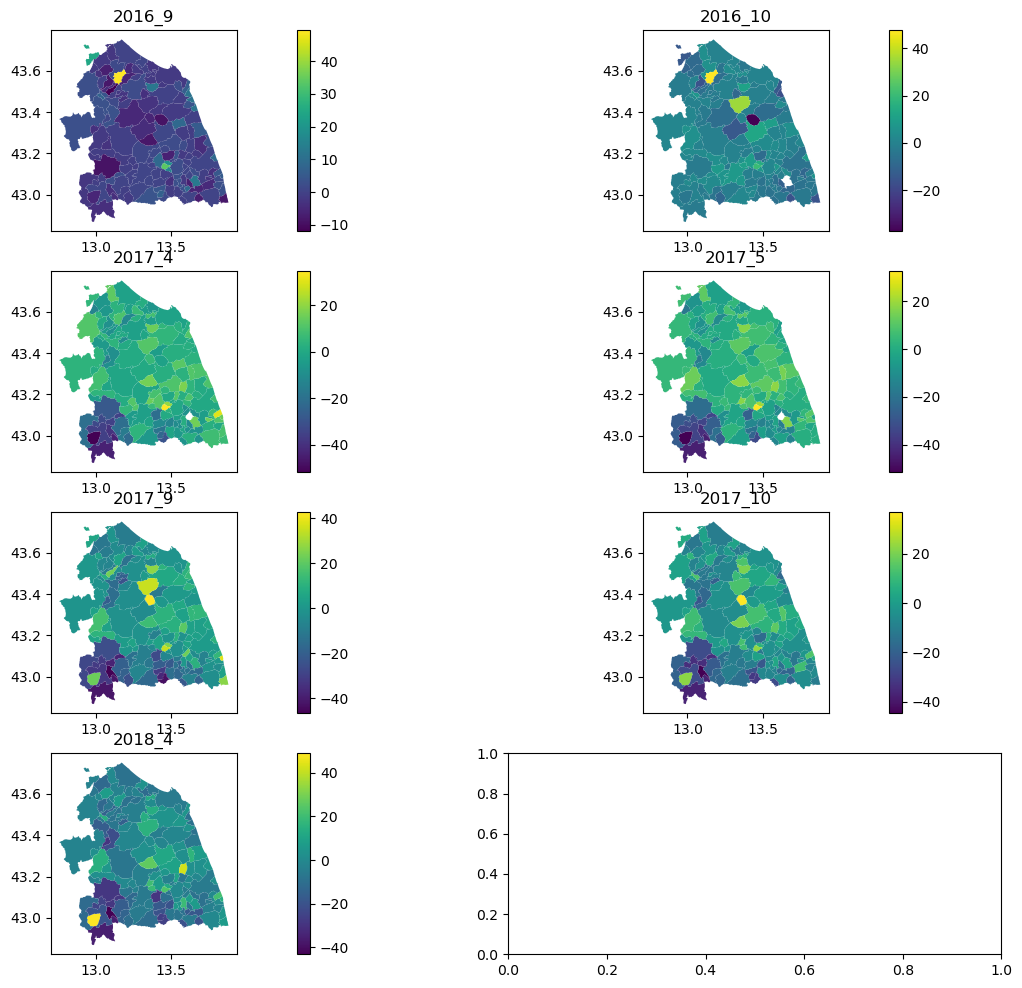

In [14]:
series = list(map_diff_clean.columns[5:])
nrows = math.ceil(len(series)/2)

plt.rcParams['figure.figsize'] = [14, 12]
fig, axes = plt.subplots(nrows=nrows, ncols=2)

k = 0
for i in range(nrows):
    for j in range(2):
        divider = make_axes_locatable(axes[i,j])
        cax = divider.append_axes("right", size="5%", pad='10%')
        axes[i,j].set_title(series[k][4:])
        map_diff_clean.plot(column=series[k], ax=axes[i,j], cax=cax, legend=True)
        k+=1
        if k == len(series):
            break
'''
divider = make_axes_locatable(axes[0,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
axes[0,0].set_title('val_2016_9')
map_diff_clean.plot(column='val_2016_9', ax=axes[0,0], cax=cax, legend=True)

divider = make_axes_locatable(axes[0,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
axes[0,1].set_title('val_2017_4')
map_diff_clean.plot(column='val_2017_4', ax=axes[0,1], cax=cax, legend=True)

divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
axes[1,0].set_title('val_2017_5')
map_diff_clean.plot(column='val_2017_5', ax=axes[1,0], cax=cax, legend=True)

divider = make_axes_locatable(axes[1,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
axes[1,1].set_title('val_2017_9')
map_diff_clean.plot(column='val_2017_9', ax=axes[1,1], cax=cax, legend=True)
'''
plt.rcParams.update(plt.rcParamsDefault)



**Fig. 5** Percentage difference in population between May 2016 (before the earthquake) and months after over a map

In [15]:


def style_function(x):
    color = '#ff0000' if x['properties']['RER_32'] == 1 else '#000000'
    fill = '#ff7777' if x['properties']['RER_32'] == 1 else '#ffffff'
    #print(x['properties']['RER_32'])
    return {'fillColor': fill, 
            'color':color, 
            'fillOpacity': 0.1, 
            'weight': 0.5}

def highlight_function(x):
    color = '#ff0000' if x['properties']['RER_32'] == 1 else '#000000'
    fill = '#990000' if x['properties']['RER_32'] == 1 else '#000000'
    return {'fillColor': fill, 
            'color':color, 
            'fillOpacity': 0.50, 
            'weight': 0.1}


simple_map = map_diff_clean.copy()
simple_map = simple_map.to_crs(epsg=4326)
simple_map['geometry'] = simple_map['geometry'].simplify(0.001, preserve_topology=False)
#myscale = (simple_map['YOY'].quantile((0,0.2,0.4,0.6,0.8,1))).tolist()
myscale = [-60, -50,-40,-30,-20,-10,0,10,20,30,40,50]

val = 'val_2018_4'


other = folium.features.GeoJson(
    simple_map,
    style_function=style_function,
    control=False,
    highlight_function=highlight_function,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['COMUNE','RER_32',val],
        aliases=['Comune: ','HQ_AREA','Change %: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
    )
)

m = folium.Map(location=[simple_map.centroid.y.mean(), simple_map.centroid.x.mean()], tiles="cartodbpositron", zoom_start=8)
folium.Choropleth(
 geo_data=simple_map,
 name='Choropleth',
 data=simple_map,
 columns=['COMUNE',val],
 key_on="feature.properties.COMUNE",
 fill_color='RdBu',
 threshold_scale=myscale,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='YOY %',
 smooth_factor=0
).add_to(m)

m.add_child(other)
m.keep_in_front(other)
folium.LayerControl().add_to(m)

for index,row in simple_map.iterrows():
    index, row
    
m

<ipython-input-15-c8fe67b71bf4>:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[simple_map.centroid.y.mean(), simple_map.centroid.x.mean()], tiles="cartodbpositron", zoom_start=8)


**Fig. 6** Percentage difference in population between May 2016 (before the earthquake) and April 2018 after over a map


In [16]:
simple_map.to_crs(epsg=4326)

,COMUNE,geometry,HQ,RER_32,val_2016_5,val_2016_9,val_2016_10,val_2017_4,val_2017_5,val_2017_9,val_2017_10,val_2018_4
0,Ripatransone,"POLYGON ((13.79857 43.03372, 13.79848 43.03135...",0.0,0.0,0,0.373485,-2.848801,7.722038,1.104820,-2.842583,-5.115354,-0.345692
1,Trecastelli,"POLYGON ((13.11299 43.72705, 13.11805 43.72832...",0.0,0.0,0,-2.348909,4.734302,13.235994,11.603933,-0.513404,1.561456,0.227669
2,Massa Fermana,"POLYGON ((13.47962 43.16622, 13.48345 43.16380...",1.0,1.0,0,18.347459,15.067413,20.792574,20.780765,25.941275,8.073439,12.440552
3,Monsampietro Morico,"POLYGON ((13.56050 43.08014, 13.56836 43.07808...",1.0,1.0,0,3.455983,-2.523321,-9.451443,-11.449111,-18.425705,-5.156413,3.967954
4,Servigliano,"POLYGON ((13.51740 43.08507, 13.51620 43.07989...",1.0,1.0,0,-3.495832,-4.980253,-13.260075,-15.268677,-21.705402,-22.517627,-19.480155
...,...,...,...,...,...,...,...,...,...,...,...,...
141,Monte Vidon Corrado,"POLYGON ((13.49009 43.13457, 13.48969 43.13195...",1.0,1.0,0,15.553111,7.990860,3.211053,1.130778,-0.818245,-11.930594,-6.592311
142,Moresco,"POLYGON ((13.73218 43.08895, 13.73404 43.08943...",0.0,0.0,0,-3.006330,-1.841818,15.379057,9.562335,0.323367,-2.648222,-5.626352
143,Montelparo,"POLYGON ((13.54387 43.04436, 13.54362 43.03964...",1.0,1.0,0,-0.303621,-5.080228,-5.588064,-10.554343,-17.319264,-7.693529,-7.777061
144,Monte Rinaldo,"POLYGON ((13.58457 43.05116, 13.59079 43.04883...",1.0,1.0,0,3.166256,-2.081980,-1.185513,-5.354045,-13.012571,-7.829619,-8.967118
